In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D, TimeDistributed
from tensorflow.keras.optimizers import AdamW

In [ ]:
!pip install tensorflow_model_optimization

In [ ]:
import tensorflow_model_optimization as tfmot

In [ ]:
'''
# Enable GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print("Failed to enable GPU memory growth:", e)
'''

In [ ]:
spatial_model_path = '/content/drive/MyDrive/MyModels/spatial_model_serialized.keras'
temporal_model_path = '/content/drive/MyDrive/MyModels/temporal_model_serialize_8.keras'

In [ ]:
# Define the custom F1-score function
@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# Define the StandardAttention layer
@tf.keras.utils.register_keras_serializable()
class StandardAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(StandardAttention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(
            name="W",
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.V = self.add_weight(
            name="V",
            shape=(self.units, 1),
            initializer="glorot_uniform",
            trainable=True,
        )
        super(StandardAttention, self).build(input_shape)

    def call(self, features):
        attention_scores = tf.keras.activations.tanh(tf.matmul(features, self.W))
        attention_weights = tf.keras.activations.sigmoid(tf.matmul(attention_scores, self.V))
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

    def get_config(self):
        config = super(StandardAttention, self).get_config()
        config.update({"units": self.units})
        return config

# Define the SqueezeLayer
@tf.keras.utils.register_keras_serializable()
class SqueezeLayer(tf.keras.layers.Layer):
    def __init__(self, axis=None, **kwargs):
        super(SqueezeLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.squeeze(inputs, axis=self.axis)

    def get_config(self):
        config = super(SqueezeLayer, self).get_config()
        config.update({"axis": self.axis})
        return config

In [ ]:
spatial_model = tf.keras.models.load_model(spatial_model_path)
spatial_model.name = 'spatial_model'  # Rename the model
print("Spatial Model Summary:")
spatial_model.summary()

Spatial Model Summary:


Model: "spatial_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 787,205 (3.00 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 524,804 (2.00 MB)

In [ ]:
temporal_model = tf.keras.models.load_model(
    temporal_model_path,
    custom_objects={
        'f1_score': f1_score,  # Add your custom F1-score function
        'StandardAttention': StandardAttention,  # Add custom layers
        'SqueezeLayer': SqueezeLayer
    }
)
temporal_model.name = 'temporal_model'  # Rename the model
print("\nTemporal Model Summary:")
temporal_model.summary()



Temporal Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 52 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "temporal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, 224, 224, 3)   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, None, 5, 5, 1536)    │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 1, 256)              │         312,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ standard_attention                   │ (None, 256)                 │          65,792 │
│ (StandardAttention)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,385,508 (230.35 MB)

 Trainable params: 5,637,505 (21.51 MB)

 Non-trainable params: 49,110,496 (187.34 MB)

 Optimizer params: 5,637,507 (21.51 MB)

In [ ]:
def rename_layers(model, prefix):
    """
    Recursively rename layers in a model and its submodels.
    Args:
        model: The model to rename.
        prefix: The prefix to add to layer names (e.g., 'spatial_' or 'temporal_').
    """
    for layer in model.layers:
        # Rename the layer
        layer.name = f'{prefix}{layer.name}'

        # If the layer is a submodel, recursively rename its layers
        if isinstance(layer, tf.keras.Model):
            rename_layers(layer, prefix)

In [ ]:
# Rename layers in the spatial model
rename_layers(spatial_model, 'spatial_')

# Rename layers in the temporal model
rename_layers(temporal_model, 'temporal_')

In [ ]:
# Check spatial model layers
print("Spatial Model Layers After Renaming:")
for layer in spatial_model.layers:
    print(layer.name)

# Check temporal model layers
print("\nTemporal Model Layers After Renaming:")
for layer in temporal_model.layers:
    print(layer.name)

Spatial Model Layers After Renaming:
spatial_input_layer_2
spatial_dense
spatial_dropout
spatial_dense_1

Temporal Model Layers After Renaming:
temporal_input_layer_1
temporal_time_distributed
temporal_functional_1
temporal_standard_attention
temporal_dense
temporal_dropout
temporal_dense_1


In [ ]:
# Unfreeze the top 20 layers of the spatial model
for layer in spatial_model.layers[-20:]:  # Unfreeze the last 20 layers (top layers)
    layer.trainable = True
for layer in spatial_model.layers[:-20]:  # Freeze all other layers
    layer.trainable = False
print("Top 20 layers of the spatial model have been unfrozen.")

Top 20 layers of the spatial model have been unfrozen.


In [ ]:
# Unfreeze the top 20 layers of InceptionResNetV2 in the temporal model
for layer in temporal_model.layers:
    if 'time_distributed' in layer.name:  # Check if the layer is TimeDistributed
        print(f"Found TimeDistributed layer: {layer.name}")

        # Access the InceptionResNetV2 model inside the TimeDistributed layer
        inception_resnet_v2_model = layer.layer
        print(f"  InceptionResNetV2 model found inside TimeDistributed layer: {inception_resnet_v2_model.name}")

        # Unfreeze the top 20 layers of InceptionResNetV2
        for layer in inception_resnet_v2_model.layers[-10:]:  # Unfreeze the last 20 layers (top layers)
            layer.trainable = True
        for layer in inception_resnet_v2_model.layers[:-10]:  # Freeze all other layers
            layer.trainable = False
        print("  Top 10 layers of InceptionResNetV2 have been unfrozen.")
    else:
        print(f"Skipping layer: {layer.name} (not TimeDistributed)")

Skipping layer: temporal_input_layer_1 (not TimeDistributed)
Found TimeDistributed layer: temporal_time_distributed
  InceptionResNetV2 model found inside TimeDistributed layer: inception_resnet_v2
  Top 10 layers of InceptionResNetV2 have been unfrozen.
Skipping layer: temporal_functional_1 (not TimeDistributed)
Skipping layer: temporal_standard_attention (not TimeDistributed)
Skipping layer: temporal_dense (not TimeDistributed)
Skipping layer: temporal_dropout (not TimeDistributed)
Skipping layer: temporal_dense_1 (not TimeDistributed)


In [ ]:
import h5py
# Load train_data from the HDF5 file
train_final_path='/content/drive/MyDrive/train_temporal_data.h5'
val_final_path='/content/drive/MyDrive/validation_temporal_data.h5'
train_final_data = []
with h5py.File(train_final_path, 'r') as f:
    for video_name in f:
        video_group = f[video_name]
        frames = video_group['frames'][:]
        label = video_group['label'][()]
        train_final_data.append((frames, label))

# Load val_data from the HDF5 file
val_final_data = []
with h5py.File(val_final_path, 'r') as f:
    for video_name in f:
        video_group = f[video_name]
        frames = video_group['frames'][:]
        label = video_group['label'][()]
        val_final_data.append((frames, label))

In [ ]:
# Create a generator function for the dataset
def dataset_generator(data):
    for frames, label in data:
        yield frames, label

# Convert the lists to TensorFlow datasets using from_generator
train_final_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(train_final_data),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3)),  # frames: (num_frames, 224, 224, 3)
        tf.TensorSpec(shape=(), dtype=tf.float32)  # label: scalar
    )
)

val_final_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(val_final_data),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3)),  # frames: (num_frames, 224, 224, 3)
        tf.TensorSpec(shape=(), dtype=tf.float32)  # label: scalar
    )
)

In [ ]:
def check_min_max_frames(dataset, dataset_name):
    print(f"Checking min and max frame values for {dataset_name}...")
    min_value = float('inf')
    max_value = float('-inf')

    for frames, label in dataset:
        # Update global min and max
        batch_min = tf.reduce_min(frames).numpy()
        batch_max = tf.reduce_max(frames).numpy()
        min_value = min(min_value, batch_min)
        max_value = max(max_value, batch_max)

    print(f"Minimum frame value in {dataset_name}: {min_value}")
    print(f"Maximum frame value in {dataset_name}: {max_value}")
    print()

# Check min and max values for train_dataset
check_min_max_frames(train_final_dataset, "train_final_dataset")

# Check min and max values for val_dataset
check_min_max_frames(val_final_dataset, "test_final_dataset")

Checking min and max frame values for train_final_dataset...
Minimum frame value in train_final_dataset: 0.0
Maximum frame value in train_final_dataset: 1.0

Checking min and max frame values for test_final_dataset...
Minimum frame value in test_final_dataset: 0.0
Maximum frame value in test_final_dataset: 1.0



In [ ]:
# Count the number of videos in each set
num_train_final_videos = len(train_final_data)
num_val_final_videos = len(val_final_data)

print(f"Number of videos in the training set: {num_train_final_videos}")
print(f"Number of videos in the val set: {num_val_final_videos}")

Number of videos in the training set: 320
Number of videos in the val set: 79


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Random horizontal flip
    tf.keras.layers.RandomRotation(0.1),      # Random rotation (±10%)
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Random translation (±10%)
    tf.keras.layers.RandomZoom(height_factor=0.1),  # Random zoom (±10%)
    tf.keras.layers.GaussianNoise(stddev=0.01),  # Add slight Gaussian noise
    tf.keras.layers.RandomContrast(factor=0.1),  # Slight contrast adjustment (±10%)
    tf.keras.layers.RandomShear(x_factor=0.1, y_factor=0.1),  # Random shear (±10%)
])

In [ ]:
def augment_data(frames, label):
    """
    Applies data augmentation to the frames.
    Args:
        frames: Tensor of shape (num_frames, 224, 224, 3)
        label: Tensor of shape ()
    Returns:
        augmented_frames: Tensor of shape (num_frames, 224, 224, 3)
        label: Tensor of shape ()
    """
    # Ensure the shape of frames is fully defined (no batch dimension)
    frames = tf.ensure_shape(frames, [None, 224, 224, 3])  # num_frames can be None

    # Debug: Print input frames min and max using tf.print
    #tf.print("Input frames min:", tf.reduce_min(frames))
    #tf.print("Input frames max:", tf.reduce_max(frames))

    # Apply augmentation to each frame in the sequence using tf.map_fn
    augmented_frames = tf.map_fn(
        lambda frame: data_augmentation(tf.expand_dims(frame, axis=0))[0],  # Add batch dimension, apply augmentation, and remove batch dimension
        frames,  # Input tensor
        fn_output_signature=tf.float32  # Output dtype and shape
    )

    # Debug: Print augmented frames min and max (before clipping) using tf.print
    #tf.print("Augmented frames min (before clipping):", tf.reduce_min(augmented_frames))
    #tf.print("Augmented frames max (before clipping):", tf.reduce_max(augmented_frames))

    # Clip pixel values to [0, 1] after augmentation
    augmented_frames = tf.clip_by_value(augmented_frames, 0.0, 1.0)

    # Debug: Print augmented frames min and max (after clipping) using tf.print
    #tf.print("Augmented frames min (after clipping):", tf.reduce_min(augmented_frames))
    #tf.print("Augmented frames max (after clipping):", tf.reduce_max(augmented_frames))

    return augmented_frames, label

# Apply augmentation to the training dataset
train_final_augmented_dataset = train_final_dataset.map(augment_data)

Frames shape: (38, 224, 224, 3)
Label value: 1.0
Frame 1 shape: (224, 224, 3)
Frame 1 min value: 0.0
Frame 1 max value: 0.8249695
Frame 1 label: 1.0


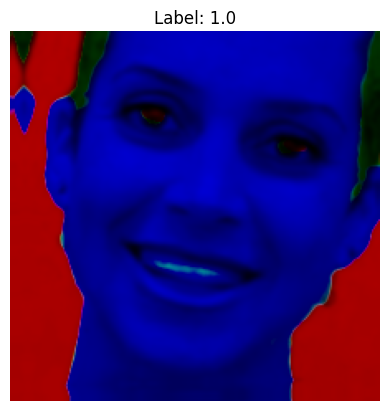

Frame 2 shape: (224, 224, 3)
Frame 2 min value: 0.0
Frame 2 max value: 0.81758606
Frame 2 label: 1.0


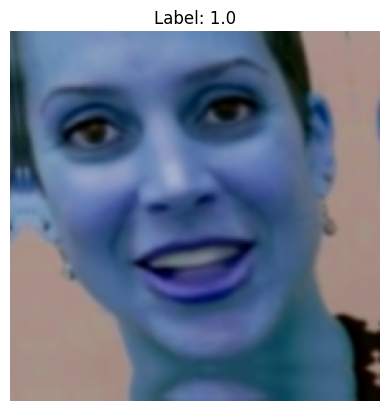

Frame 3 shape: (224, 224, 3)
Frame 3 min value: 0.0
Frame 3 max value: 0.8238918
Frame 3 label: 1.0


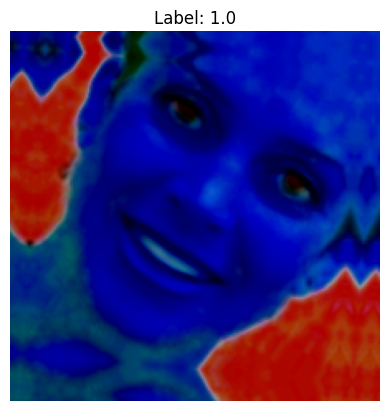

Frame 4 shape: (224, 224, 3)
Frame 4 min value: 0.0
Frame 4 max value: 0.83517873
Frame 4 label: 1.0


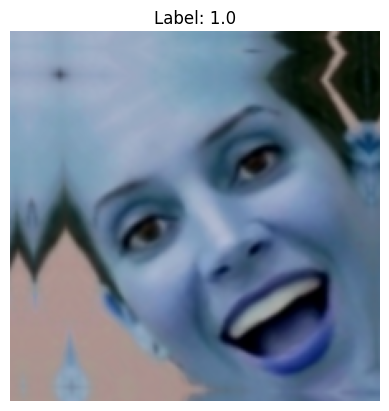

Frame 5 shape: (224, 224, 3)
Frame 5 min value: 0.0
Frame 5 max value: 0.83614445
Frame 5 label: 1.0


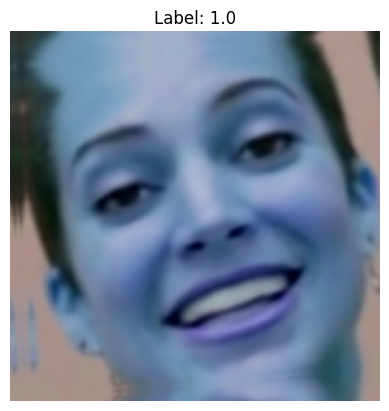

In [ ]:
from matplotlib import pyplot as plt

def visualize_augmented_data(dataset, num_samples=5):
    """
    Visualizes a few augmented frames from the dataset.
    Args:
        dataset: The augmented dataset (e.g., train_augmented_dataset).
        num_samples: Number of frames to visualize.
    """
    # Take one batch from the dataset
    for frames, label in dataset.take(1):  # Take one batch (unbatched)
        print("Frames shape:", frames.shape)  # Debug: Check the shape of the frames
        print("Label value:", label.numpy())  # Debug: Check the value of the label

        # Iterate over the first few frames in the batch
        for i in range(min(num_samples, frames.shape[0])):  # Iterate over frames
            frame = frames[i]  # Extract the i-th frame

            print(f"Frame {i + 1} shape:", frame.shape)  # Debug: Check the shape of the individual frame
            print(f"Frame {i + 1} min value:", tf.reduce_min(frame).numpy())  # Debug: Check min pixel value
            print(f"Frame {i + 1} max value:", tf.reduce_max(frame).numpy())  # Debug: Check max pixel value
            print(f"Frame {i + 1} label:", label.numpy())  # Debug: Check the label value

            # Display the augmented frame
            plt.imshow(frame.numpy())  # Convert TensorFlow tensor to NumPy array for visualization
            plt.title(f"Label: {label.numpy()}")  # Use the scalar label
            plt.axis('off')  # Hide axes
            plt.show()
# Visualize augmented frames
visualize_augmented_data(train_final_augmented_dataset, num_samples=5)

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

# Load a pre-trained Xception model (without the top classification layer)
feature_extractor = Xception(weights='imagenet', include_top=False, pooling='avg')

def extract_features(frame):
    """
    Extracts a feature vector from a raw frame using a pre-trained model.
    Args:
        frame: Tensor of shape (224, 224, 3).
    Returns:
        A feature vector of shape (2048,).
    """
    # Preprocess the frame (resize, normalize, etc.)
    frame = tf.image.resize(frame, (299, 299))  # Xception expects (299, 299, 3)
    frame = preprocess_input(frame)  # Normalize for Xception
    frame = tf.expand_dims(frame, axis=0)  # Add batch dimension: (1, 299, 299, 3)

    # Extract features
    features = feature_extractor(frame)  # Shape: (1, 2048)
    return tf.squeeze(features, axis=0)  # Remove batch dimension: (2048,)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
def prepare_inputs(frames, label):
    """
    Prepares inputs for the final model.
    """
    # Extract spatial features from every frame
    spatial_features = tf.map_fn(
        lambda frame: extract_features(frame),  # Extract features for each frame
        frames,  # Input tensor: (num_frames, 224, 224, 3)
        fn_output_signature=tf.float32  # Output dtype and shape: (num_frames, 2048)
    )

    # Average the spatial features across frames to get a single spatial feature vector
    spatial_input = tf.reduce_mean(spatial_features, axis=0)  # Shape: (2048,)

    # Temporal input: Use the entire sequence of frames
    temporal_input = frames  # Shape: (num_frames, 224, 224, 3)

    return {'spatial_input': spatial_input, 'temporal_input': temporal_input}, label

In [ ]:
# Apply the prepare_inputs function to the training dataset
batch_size = 4
train_final_loader = train_final_augmented_dataset.map(prepare_inputs).padded_batch(
    batch_size=batch_size,
    padded_shapes=(
        {'spatial_input': [2048], 'temporal_input': [None, 224, 224, 3]},  # Corrected shapes
        []  # Label shape
    )
).prefetch(tf.data.experimental.AUTOTUNE)

# Apply the prepare_inputs function to the validation dataset
val_final_loader = val_final_dataset.map(prepare_inputs).padded_batch(
    batch_size=batch_size,
    padded_shapes=(
        {'spatial_input': [2048], 'temporal_input': [None, 224, 224, 3]},  # Corrected shapes
        []  # Label shape
    )
).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Take a sample batch from the train_loader
for batch in train_final_loader.take(1):
    inputs, labels = batch
    print("Spatial input shape:", inputs['spatial_input'].shape)  # Should be (batch_size, 224, 224, 3)
    print("Temporal input shape:", inputs['temporal_input'].shape)  # Should be (batch_size, num_frames, 224, 224, 3)
    print("Labels shape:", labels.shape)  # Should be (batch_size,)
    break

Spatial input shape: (4, 2048)
Temporal input shape: (4, 54, 224, 224, 3)
Labels shape: (4,)


In [ ]:
# Calculate the number of validation samples
test_final_fraction = 0.01  # 1% of the training data
num_val_final_samples = len(val_final_data)  # Total number of training samples
num_test_final_samples = int(num_val_final_samples * test_final_fraction)  # Number of validation samples

In [ ]:
# Take a small fraction of the augmented training data for validation
test_final_loader = val_final_loader.take(num_test_final_samples)

# Use the remaining data for training
val_final_loader_1 = val_final_loader.skip(num_test_final_samples)

In [ ]:
'''
# Print the sizes of the data loaders
print(f"Number of batches in train_loader (full): {len(list(train_final_loader))}")
print(f"Number of batches in val_loader: {len(list(val_final_loader))}")
print(f"Number of batches in train_loader_remaining: {len(list(train_final_loader_1))}")
print(f"Number of batches in test_loader: {len(list(test_final_loader))}")
'''

In [ ]:
from tensorflow.keras.layers import LayerNormalization, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model

def build_DeepFakeDetectionModel(spatial_model, temporal_model):
    """
    Build the final DeepFakeDetectionModel by combining spatial and temporal models.
    """
    # Input for spatial model (features from spatial model)
    spatial_input = Input(shape=(2048,), name='spatial_input')  # Shape: (None, 2048)

    # Pass through the spatial model (ensure it outputs a feature vector)
    spatial_features = spatial_model(spatial_input)  # Shape: (None, 2048)

    # Input for temporal model (sequence of frames)
    temporal_input = Input(shape=(None, 224, 224, 3), name='temporal_input')  # Shape: (None, None, 224, 224, 3)

    # Pass through the temporal model (ensure it outputs a feature vector)
    temporal_features = temporal_model(temporal_input)  # Shape: (None, 256)

    # Feature fusion: Concatenate spatial and temporal features
    combined_features = Concatenate()([spatial_features, temporal_features])  # Shape: (None, 2048 + 256)

    # Add a dense layer to learn the best combination of features
    x = Dense(
        1024,  # Increased number of units
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)  # L2 regularization
    )(combined_features)
    x = LayerNormalization()(x)  # Replace BatchNorm with LayerNorm
    x = Dropout(0.5)(x)  # Add dropout for regularization

    # Add another dense layer for further processing
    x = Dense(
        512,  # Reduced number of units
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)  # L2 regularization
    )(x)
    x = LayerNormalization()(x)  # Replace BatchNorm with LayerNorm
    x = Dropout(0.6)(x)  # Add dropout for regularization

    # Add a third dense layer for additional processing
    x = Dense(
        256,  # Additional dense layer
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)  # L2 regularization
    )(x)
    x = LayerNormalization()(x)  # Replace BatchNorm with LayerNorm
    x = Dropout(0.7)(x)  # Add dropout for regularization

    # Final output layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Build the final model
    final_model = Model(inputs=[spatial_input, temporal_input], outputs=outputs, name='DeepFakeDetectionModel')

    return final_model

In [ ]:
# Build the final model
final_model = build_DeepFakeDetectionModel(spatial_model, temporal_model)

# Print the model summary
final_model.summary()

Model: "DeepFakeDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ spatial_input             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ temporal_input            │ (None, None, 224, 224, │              0 │ -                      │
│ (InputLayer)              │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_model             │ (None, 1)              │        262,401 │ spatial_input[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ temporal_model            │ (None, 1)              │     54,748,001 │ temporal_input[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2)              │              0 │ spatial_model[0][0],   │
│                           │                        │                │ temporal_model[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024)           │          3,072 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 1024)           │          2,048 │ dense[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1024)           │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        524,800 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 512)            │          1,024 │ dense_1[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 256)            │            512 │ dense_2[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            257 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 55,673,443 (212.38 MB)

 Trainable params: 5,462,755 (20.84 MB)

 Non-trainable params: 50,210,688 (191.54 MB)

In [ ]:
from tensorflow.keras.optimizers import AdamW

optimizer = AdamW(
    learning_rate=1e-4,  # Increased learning rate
    weight_decay=1e-4,    # Weight decay (L2 regularization)
    beta_1=0.9,           # Exponential decay rate for the first moment estimates
    beta_2=0.999,         # Exponential decay rate for the second moment estimates
    epsilon=1e-07         # Small constant for numerical stability
)

# Compile the final model with AdamW
final_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,          # Reduce learning rate by 50%
    patience=3,          # Wait for 3 epochs without improvement
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print a message when learning rate is reduced
)

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs without improvement
    restore_best_weights=True,  # Restore the best model weights
    verbose=1            # Print a message when training stops
)


In [ ]:
train_final_loader=train_final_loader.repeat()
val_final_loader_1=val_final_loader_1.repeat()
test_final_loader=test_final_loader.repeat()

In [ ]:
#steps for training and validation
steps_per_epoch = 20
validation_steps = 5

In [ ]:
# Train the final model
history = final_model.fit(
    train_final_loader,  # Use the training data loader
    validation_data=val_final_loader_1,  # Use the validation data loader
    epochs=20,  # Adjust epochs as needed
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch
    validation_steps=validation_steps,  # Number of validation steps
    callbacks=[reduce_lr, early_stopping]  # Add callbacks
)

In [ ]:
# Save the best weights to a file
final_model.save_weights('best_model_weights.weights.h5')
print("Best weights saved to 'best_model_weights.weights.h5'.")

# Verify that the file exists
import os
if os.path.exists('best_model_weights.weights.h5'):
    print("File saved successfully.")
else:
    print("File not found. Check the file path and permissions.")

Best weights saved to 'best_model_weights.weights.h5'.
File saved successfully.


In [ ]:
# Load the best weights into the model
final_model.load_weights('best_model_weights.weights.h5')
print("Best weights loaded into the model.")

Best weights loaded into the model.


In [ ]:
# Calculate the number of validation samples
test_final_fraction = 0.01  # 1% of the training data
num_train_final_samples = len(train_final_data)  # Total number of training samples
num_test_final_samples = int(num_train_final_samples * test_final_fraction)  # Number of validation samples
# Take a small fraction of the augmented training data for validation
test_final_loader = train_final_loader.take(num_test_final_samples)
test_final_loader=test_final_loader.repeat()


In [ ]:
# Evaluate the model with the best weights
results = final_model.evaluate(test_final_loader, steps=3)
results

3/3 ━━━━━━━━━━━━━━━━━━━━ 90s 25s/step - accuracy: 0.7917 - loss: 0.5889


[0.56337571144104, 0.8333333134651184]

**-------------------------------------------**